In [1]:
# !pip install tensorflow==2.6.1

For some reason, latest keras version (2.7) was causing problem. So..

In [2]:
# !pip3 uninstall keras

In [3]:
# !pip3 install keras==2.6.0

In [4]:
import tensorflow as tf
import os, shutil

print(tf.__version__)

2.6.1


In [5]:
MODEL_LOCATION='export/explainable_fire_model'  # will be created

In [6]:
# load from checkpoint and export a model that has desired signature
CHECK_POINT_DIR='gs://fire_detection_anurag/models/accuracy/chkpts'
model = tf.keras.models.load_model(CHECK_POINT_DIR)

In [7]:
IMG_HEIGHT = 448  # same value as used while model training
IMG_WIDTH = IMG_HEIGHT
IMG_CHANNELS = 3
CLASS_NAMES = 'Fire No-Fire'.split()

Helper functions

In [8]:
def preprocess(filename):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)


@tf.function(input_signature=[tf.TensorSpec([None,
                                             IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS],
                                            dtype=tf.float32)])
def xai_model(input_images):
    batch_pred = model(input_images) # same as model.predict()
    top_prob = tf.math.reduce_max(batch_pred,
                                  axis=[1])
    pred_label_index = tf.math.argmax(batch_pred,
                                      axis=1)
    pred_label = tf.gather(tf.convert_to_tensor(CLASS_NAMES),
                           pred_label_index)
    return {
            'probability': top_prob,
            'image_type_int': pred_label_index,
            'image_type_str': pred_label
           }

@tf.function(input_signature=[tf.TensorSpec([None,],
                                            dtype=tf.string)])
def xai_preprocess(filenames):
    input_images = tf.map_fn(
                            preprocess,
                            filenames,
                            fn_output_signature=tf.float32
                            )
    return {
            # match the signature of xai_model
            'input_images': input_images
           }

@tf.function(input_signature=[tf.TensorSpec([None,],
                                            dtype=tf.string)])
def predict_filename(filenames):
    preproc_output = xai_preprocess(filenames)
    return xai_model(**preproc_output)

In [9]:
shutil.rmtree('export',
              ignore_errors=True)
os.mkdir('export')

model.save(MODEL_LOCATION,
           signatures={
                       'serving_default': predict_filename,
                       'xai_preprocess': xai_preprocess,  # should be exactly what's supplied to model
                       'xai_model': xai_model  # call the model
                      }
          )

INFO:tensorflow:Assets written to: export/explainable_fire_model/assets


In [10]:
!saved_model_cli show --dir {MODEL_LOCATION} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['filenames'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_filenames:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['image_type_int'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: StatefulPartitionedCall:0
    outputs['image_type_str'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: StatefulPartitionedCall:1
    outputs['probability'] tensor_info:
        dty

In [11]:
filenames = tf.io.gfile.glob("gs://fire_detection_anurag/test_images/*")

filenames

['gs://fire_detection_anurag/test_images/fire1.jpg',
 'gs://fire_detection_anurag/test_images/fire2.jpg',
 'gs://fire_detection_anurag/test_images/fire3.jpg',
 'gs://fire_detection_anurag/test_images/fire4.jpg',
 'gs://fire_detection_anurag/test_images/fire5.jpg',
 'gs://fire_detection_anurag/test_images/no_fire1.jpg',
 'gs://fire_detection_anurag/test_images/no_fire2.jpg',
 'gs://fire_detection_anurag/test_images/no_fire3.jpg',
 'gs://fire_detection_anurag/test_images/no_fire4.jpg',
 'gs://fire_detection_anurag/test_images/no_fire5.jpg',
 'gs://fire_detection_anurag/test_images/prediction-fire20211105140403-2021-11-05T15:04:29.256648Z',
 'gs://fire_detection_anurag/test_images/test.jsonl']

In [12]:
serving_fn = tf.keras.models.load_model(MODEL_LOCATION).signatures['serving_default']

pred = serving_fn(tf.convert_to_tensor(filenames[:5]))  # TODO: why for only 1 class?
print(pred)

{'probability': <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.99452174, 0.71165925, 0.98736054, 0.9839685 , 0.9958753 ],
      dtype=float32)>, 'image_type_int': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>, 'image_type_str': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Fire', b'Fire', b'Fire', b'Fire', b'Fire'], dtype=object)>}


In [13]:
[filenames[1]]

['gs://fire_detection_anurag/test_images/fire2.jpg']

In [14]:
serving_fn = tf.keras.models.load_model(MODEL_LOCATION).signatures['xai_preprocess']
filename = [filenames[1]]

pred = serving_fn(tf.convert_to_tensor(filename))
print(pred)

{'input_images': <tf.Tensor: shape=(1, 448, 448, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0.

In [15]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
import numpy as np

np.random.seed(42)

export_path=MODEL_LOCATION  # save with model

# We want to explain 'xai_model' signature.
builder = SavedModelMetadataBuilder(
                                    export_path,
                                    signature_name='xai_model',
                                    outputs_to_explain=['probability']
                                   )

# baseline (of random pixel values) to compare with
random_baseline = np.random.rand(IMG_HEIGHT, IMG_WIDTH, 3)  # TODO: See impact by changing baseline

builder.set_image_metadata(
                            'input_images',
                            input_baselines=[random_baseline.tolist()]
                          )

builder.save_metadata(export_path)

**Note**: In this case, the metadata.json file ended up having of size of > 25 MB.

In [16]:
!head -20 {MODEL_LOCATION}/explanation_metadata.json

{
  "outputs": {
    "probability": {
      "output_tensor_name": "probability"
    }
  },
  "inputs": {
    "input_images": {
      "input_tensor_name": "input_images",
      "encoding": "identity",
      "modality": "image",
      "input_baselines": [
        [
          [
            [
              0.3745401188473625,
              0.9507143064099162,
              0.7319939418114051
            ],
            [


In [17]:
%%writefile caip_deploy_regional.sh
#!/bin/bash

MODEL_NAME=fire_detection
MODEL_LOCATION="gs://fire_detection_anurag/models/accuracy/chkpts"  # will change when we call script
VERSION_NAME=ig
REGION='us-central1'
EXPLAIN="--explanation-method integrated-gradients --num-integral-steps 25"
BUCKET='fire_detection_staging'  # for staging


while [[ "$#" -gt 0 ]]; do
    case $1 in
        -v|--version) VERSION_NAME="$2"; shift ;;
        -m|--model_location) MODEL_LOCATION="$2"; shift ;;
        *) echo "Unknown parameter passed: $1"; exit 1 ;;
    esac
    shift
done

if [[ "$VERSION_NAME" -eq "xrai" ]]; then
   EXPLAIN="--explanation-method xrai --num-integral-steps 25"
fi

echo "Deploying $MODEL_NAME:$VERSION_NAME with $EXPLAIN from $MODEL_LOCATION"

if [[ $(gcloud ai-platform models list --region=$REGION --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "The model named $MODEL_NAME already exists."
else
    # create model
    echo "Creating $MODEL_NAME model now."
    gcloud ai-platform models create --region=$REGION --enable-logging $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --region=$REGION --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting the already existing model $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --quiet --region=$REGION --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this script again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME $EXPLAIN"
gcloud beta ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --region=$REGION  --machine-type n1-standard-4 \
       --framework=tensorflow --python-version=3.7 --runtime-version=2.6 \
       --origin=$MODEL_LOCATION --staging-bucket=gs://$BUCKET $EXPLAIN

Overwriting caip_deploy_regional.sh


'num-integral-steps' is the no. of steps b/w the baseline image and the original/input image, for numerical integration.
The more the no. of such steps, more accurate the result is. Flipside: It will also be more computationally intensive.

In [18]:
!bash ./caip_deploy_regional.sh --model_location {MODEL_LOCATION}

Deploying fire_detection:ig with --explanation-method xrai --num-integral-steps 25 from export/explainable_fire_model
Using endpoint [https://us-central1-ml.googleapis.com/]
The model named fire_detection already exists.
Using endpoint [https://us-central1-ml.googleapis.com/]
Deleting the already existing model fire_detection:ig ... 
Using endpoint [https://us-central1-ml.googleapis.com/]
Deleting version [ig]......done.                                               
Please run this script again if you don't see a Creating message ... 
Creating fire_detection:ig --explanation-method xrai --num-integral-steps 25
Using endpoint [https://us-central1-ml.googleapis.com/]
Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.


Wait for the model and its version to show up (green tickmark) on Google Cloud console, before geting predictions in next few cells..

In [19]:
%%writefile request.json
{
 "instances": [
               {
                "filenames": "gs://fire_detection_anurag/test_images/fire1.jpg"
               },
               {
                "filenames": "gs://fire_detection_anurag/test_images/fire2.jpg"
               },
               {
                "filenames": "gs://fire_detection_anurag/test_images/fire3.jpg"
               },
               {
                "filenames": "gs://fire_detection_anurag/test_images/fire4.jpg"
               },
               {
                "filenames": "gs://fire_detection_anurag/test_images/fire5.jpg"
               }
             ]
}

Overwriting request.json


## Integrated Gradients (IG) method

It tends to perform well on low-contrast images e.g. X-rays

In [20]:
!gcloud ai-platform predict --region=us-central1 --model=fire_detection --version=ig --json-request=request.json

Using endpoint [https://us-central1-ml.googleapis.com/]
IMAGE_TYPE_INT  IMAGE_TYPE_STR  PROBABILITY
0               Fire            0.994522
0               Fire            0.711659
0               Fire            0.987361
0               Fire            0.983968
0               Fire            0.995875


In [22]:
!gcloud beta ai-platform explain \
    --region=us-central1 \
    --model=fire_detection \
    --version=ig \
    --json-request=request.json > response.json

Using endpoint [https://us-central1-ml.googleapis.com/]


In [23]:
import json
import base64

input_images = []

with open('request.json') as ifp:
    instances = json.load(ifp)['instances']
    for instance in instances:
        img_bytes = tf.io.read_file(instance['filenames'])
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
        input_images.append(img.numpy())
        
        
explain_images = []

with open('response.json') as ifp:
    explanations = json.load(ifp)['explanations']
    for expln in explanations:
        b64bytes = expln['attributions_by_label'][0]['attributions']['input_images']['b64_jpeg']
        img_bytes = base64.b64decode(b64bytes)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        explain_images.append(img.numpy())
        print("approx error = {}".format(expln['attributions_by_label'][0]['approx_error']))

approx error = 388.7658177672386
approx error = 0.5301484469971384
approx error = 23.408492890400964
approx error = 4.686638024218358
approx error = 194.57653895202202


**Interpretation**: Since the error looks too high in some cases, perhaps we should take a step back, increase value of 'num-integral-steps' and check error values again.

In [24]:
type(input_images)

list

In [25]:
len(input_images)

5

In [26]:
input_images[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

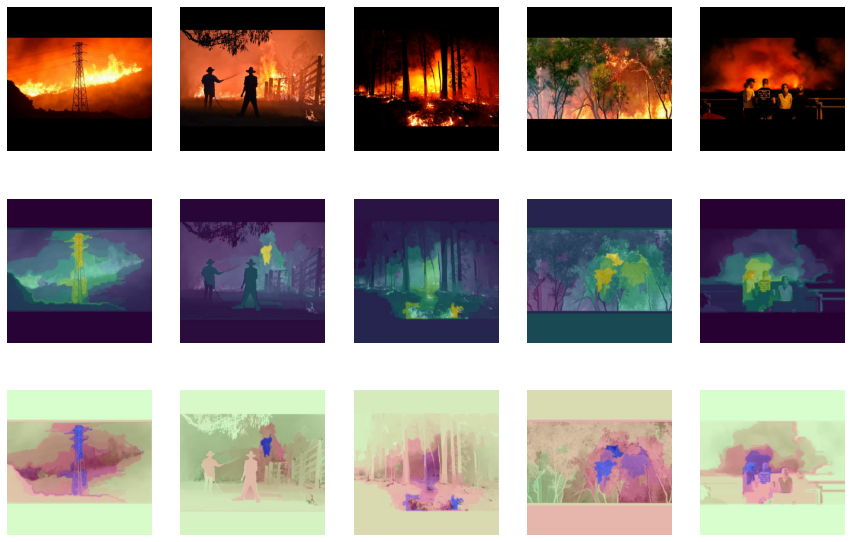

In [28]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(3, 5,
                     figsize=(15,10))

for idx in range(len(input_images)):
    ax[0, idx].imshow(input_images[idx])
    ax[1, idx].imshow(explain_images[idx])
    ax[2, idx].imshow(1-explain_images[idx])
    
    ax[0, idx].axis('off')
    ax[1, idx].axis('off')
    ax[2, idx].axis('off')

**Interpretation**: Results for images 2 & 3 (from left) look fine, since max. importance is being given to that part of the image where the burning flame is brightest. 

Results for images 4 & 5 have results which are mixed. Though they do rightly focus on bright flame areas, but they also include parts which they shouldn't have. e.g. portion of trees and individuals in images 4 and 5 respectively.

Result for image 1 certainly suggests **something is not right**. The upper half of the electricity tower seems to be getting most attention, rather than the fire engulfing the field/hill elsewhere in the picture.

So what should be the **next steps** ahead? Options:
- Check whether there are lot of images with electricity tower, categorized as "Fire". In that case, we might have inadvertently ended up inducing a **possible bias** in our model.
- Compare the difference after increasing value of **'num-integral-steps'**.
- Check explainability results for 1. images of "No Fire" label as well 2. images of "Fire" label but those which show something in **daylight** (rather than just those at night, as is the case in our sample 5 images chosen above)
- Add more images for model training, preferably in different conditions.
- Do some more data **augmentation** before/while training.

## XRAI method

It tends to perform well on natural images e.g. those depicting house, landscape etc.

In [29]:
!bash ./caip_deploy_regional.sh --model_location {MODEL_LOCATION} --version xrai

Deploying fire_detection:xrai with --explanation-method xrai --num-integral-steps 25 from export/explainable_fire_model
Using endpoint [https://us-central1-ml.googleapis.com/]
The model named fire_detection already exists.
Using endpoint [https://us-central1-ml.googleapis.com/]
Creating fire_detection:xrai --explanation-method xrai --num-integral-steps 25
Using endpoint [https://us-central1-ml.googleapis.com/]
Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.


Wait for the model and its version to show up (green tickmark) on Google Cloud console, before geting predictions in next few cells..

In [30]:
!gcloud beta ai-platform explain \
    --region=us-central1 \
    --model=fire_detection \
    --version=xrai \
    --json-request=request.json > response.json

Using endpoint [https://us-central1-ml.googleapis.com/]


In [31]:
input_images = []
with open('request.json') as ifp:
    instances = json.load(ifp)['instances']
    for instance in instances:
        img_bytes = tf.io.read_file(instance['filenames'])
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
        input_images.append(img.numpy())
        
explain_images = []
with open('response.json') as ifp:
    explanations = json.load(ifp)['explanations']
    for expln in explanations:
        b64bytes = expln['attributions_by_label'][0]['attributions']['input_images']['b64_jpeg']
        img_bytes = base64.b64decode(b64bytes)
        img = tf.image.decode_jpeg(img_bytes, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        explain_images.append(img.numpy())
        print("approx error = {}".format(expln['attributions_by_label'][0]['approx_error']))

approx error = 388.7658177672386
approx error = 0.5301484469971384
approx error = 23.408492890400964
approx error = 4.686638024218358
approx error = 194.57653895202202


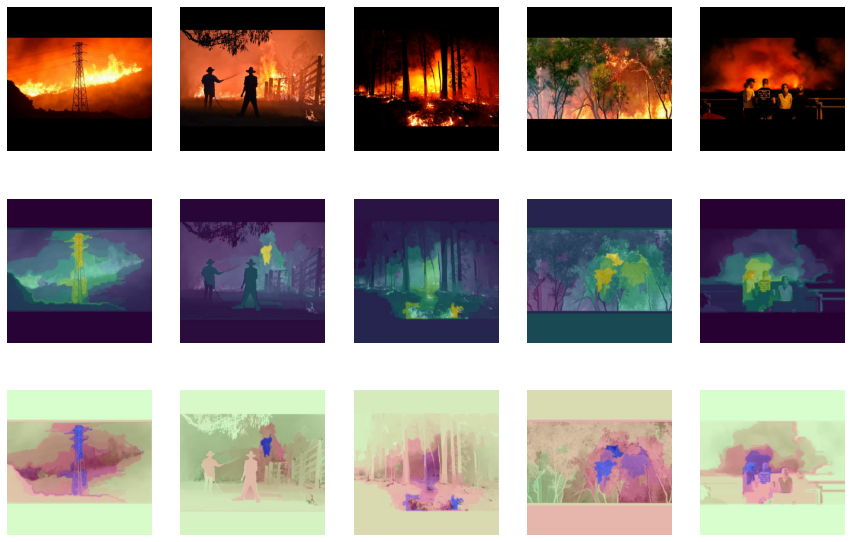

In [32]:
f, ax = plt.subplots(3, 5,
                     figsize=(15,10))

for idx in range(len(input_images)):
    ax[0, idx].imshow(input_images[idx])
    ax[1, idx].imshow(explain_images[idx])
    ax[2, idx].imshow(1-explain_images[idx])
    
    ax[0, idx].axis('off')
    ax[1, idx].axis('off')
    ax[2, idx].axis('off')

**TODO**: How come XRAI results are exactly the same as those of IG method? Need to check. WIP.